# Backtesting

---

### Import Libraries and Dependencies

In [25]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path

### Read CSV into Pandas DataFrame

In [26]:
# Set the file path
filepath = Path("link_btc_1hr.csv")

# Read the CSV located at the file path into a Pandas DataFrame
link_df = pd.read_csv(filepath, parse_dates=True, infer_datetime_format=True)

# Print the DataFrame
link_df.head()

,timestamp,LINK Close
0,2017-09-28 08:00:00.000,0.000030
1,2017-09-28 09:00:00.000,0.000046
2,2017-09-28 10:00:00.000,0.000065
3,2017-09-28 11:00:00.000,0.000067
4,2017-09-28 12:00:00.000,0.000060


In [27]:
link_df = link_df.rename(columns={'timestamp':'Timestamp','LINK Close':'Close'})

In [28]:
link_df.set_index(pd.to_datetime(link_df['Timestamp'], infer_datetime_format=True), inplace=True)
link_df.drop(columns=['Timestamp'], inplace=True)

In [29]:
link_df = link_df.loc['2020-06-11 01:00:00':'2020-07-11 01:00:00']

In [30]:
link_df['Delta'] = link_df['Close'].diff()
link_df = link_df.dropna()

In [31]:
# Make the positive gains (up) and negative gains (down) Series
up, down = link_df['Delta'].copy(), link_df['Delta'].copy()
up[up < 0] = 0
down[down > 0] = 0

In [32]:
window_length = 14

In [33]:
# Calculate the EWMA
roll_up1 = up.ewm(span=window_length).mean()
roll_down1 = down.abs().ewm(span=window_length).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
link_df['RSI1'] = 100.0 - (100.0 / (1.0 + RS1))

In [34]:
# Construct a short/long trading signal
link_df['short'] = np.where(link_df['RSI1'] > 70, -1.0, 0.0)
link_df['long'] = np.where(link_df['RSI1'] < 30, 1.0, 0.0)
link_df['rsi_signal'] = link_df['short'] + link_df['long']

In [35]:
# Grab just the `date` and `close` from the dataset
signals_df = link_df.loc[:, ['Close','RSI1']].copy()


In [36]:
signals_df.head()

,Close,RSI1
Timestamp,,
2020-06-11 02:00:00,0.000447,0.000000
2020-06-11 03:00:00,0.000446,0.000000
2020-06-11 04:00:00,0.000445,0.000000
2020-06-11 05:00:00,0.000445,0.000000
2020-06-11 06:00:00,0.000447,43.740253


### Generate a Dual Moving Average Crossover Trading Signal

In [37]:
# Construct a short/long trading signal
signals_df['short'] = np.where(signals_df['RSI1'] > 70, -1.0, 0.0)
signals_df['long'] = np.where(signals_df['RSI1'] < 30, 1.0, 0.0)
signals_df['rsi_signal'] = signals_df['short'] + signals_df['long']

# Print the DataFrame
signals_df.tail(10)

,Close,RSI1,short,long,rsi_signal
Timestamp,,,,,
2020-07-10 16:00:00,0.000659,70.152541,-1.0,0.0,-1.0
2020-07-10 17:00:00,0.000650,58.096787,0.0,0.0,0.0
2020-07-10 18:00:00,0.000658,64.145364,0.0,0.0,0.0
2020-07-10 19:00:00,0.000663,67.930058,0.0,0.0,0.0
2020-07-10 20:00:00,0.000665,69.679344,0.0,0.0,0.0
2020-07-10 21:00:00,0.000658,58.345594,0.0,0.0,0.0
2020-07-10 22:00:00,0.000662,62.795763,0.0,0.0,0.0
2020-07-10 23:00:00,0.000662,61.901785,0.0,0.0,0.0
2020-07-11 00:00:00,0.000671,69.746601,0.0,0.0,0.0


### Plot Entry and Exit Points of Dual Moving Average Crossover Trading Strategy

In [38]:
# Visualize exit position relative to close price
exit = link_df[link_df['rsi_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='BTC/USD',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = link_df[link_df['rsi_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='BTC/USD',
    width=1000,
    height=400
)
# Visualize close price for the investment
security_close = link_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Closing Price',
    width=1000,
    height=400
)


In [39]:
entry_exit_plot = security_close * entry * exit #* RSIs

entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

### Backtest the Trading Strategy

In [40]:
# Set initial capital
initial_capital = float(100)

# Set the share size
coin_size = 10000

# Take a 10 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
signals_df['Position'] = coin_size * signals_df['rsi_signal']

# Find the points in time where a 500 share position is bought or sold
signals_df['Entry/Exit Position'] = signals_df['Position']

# Multiply share price by entry/exit positions and get the cumulatively sum
signals_df['Portfolio Holdings'] = signals_df['Close'] * signals_df['Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
signals_df['Portfolio Cash'] = initial_capital - (signals_df['Close'] * signals_df['Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

# Calculate the portfolio daily returns
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

# Calculate the cumulative returns
signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
signals_df

,Close,RSI1,short,long,rsi_signal,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Timestamp,,,,,,,,,,,,
2020-06-11 02:00:00,0.000447,0.000000,0.0,1.0,1.0,10000.0,10000.0,4.4717,95.5283,100.0000,NaN,NaN
2020-06-11 03:00:00,0.000446,0.000000,0.0,1.0,1.0,10000.0,10000.0,8.9230,91.0668,99.9898,-0.000102,-0.000102
2020-06-11 04:00:00,0.000445,0.000000,0.0,1.0,1.0,10000.0,10000.0,13.3647,86.6119,99.9766,-0.000132,-0.000234
2020-06-11 05:00:00,0.000445,0.000000,0.0,1.0,1.0,10000.0,10000.0,17.8112,82.1591,99.9703,-0.000063,-0.000297
2020-06-11 06:00:00,0.000447,43.740253,0.0,0.0,0.0,0.0,0.0,17.8624,82.1591,100.0215,0.000512,0.000215
2020-06-11 07:00:00,0.000447,47.078883,0.0,0.0,0.0,0.0,0.0,17.8688,82.1591,100.0279,0.000064,0.000279
2020-06-11 08:00:00,0.000447,43.027808,0.0,0.0,0.0,0.0,0.0,17.8600,82.1591,100.0191,-0.000088,0.000191
2020-06-11 09:00:00,0.000446,42.078302,0.0,0.0,0.0,0.0,0.0,17.8580,82.1591,100.0171,-0.000020,0.000171
2020-06-11 10:00:00,0.000446,35.255843,0.0,0.0,0.0,0.0,0.0,17.8428,82.1591,100.0019,-0.000152,0.000019


In [42]:
#Set up a column holding the daily returns
signals_df_daily_returns = signals_df['Close'].pct_change()

In [43]:
signals_df_strategy_returns = signals_df['Portfolio Cumulative Returns']

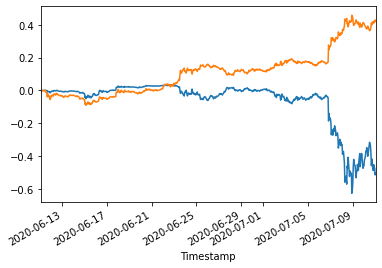

In [56]:
from matplotlib import pyplot as plt
ax = signals_df_strategy_returns.plot()
signals_df_daily_returns.cumsum().plot(ax=ax)



# Plot Entry/Exit Points of Backtest Results

In [19]:
# Visualize exit position relative to total portfolio value
exit = signals_df[signals_df['rsi_signal'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = signals_df[signals_df['rsi_signal'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize total portoflio value for the investment
total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                    :Curve   [Timestamp]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Timestamp]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Timestamp]   (Portfolio Total)

In [20]:
signals_df.to_csv('link_trading_signals.csv')

In [17]:
link_rsi_position = signals_df.copy()

In [18]:
link_rsi_position.head()

,Close,RSI1,short,long,rsi_signal,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Timestamp,,,,,,,,,,,,
2020-06-11 02:00:00,0.000447,0.000000,0.0,1.0,1.0,10000.0,10000.0,4.4717,95.5283,100.0000,NaN,NaN
2020-06-11 03:00:00,0.000446,0.000000,0.0,1.0,1.0,10000.0,10000.0,8.9230,91.0668,99.9898,-0.000102,-0.000102
2020-06-11 04:00:00,0.000445,0.000000,0.0,1.0,1.0,10000.0,10000.0,13.3647,86.6119,99.9766,-0.000132,-0.000234
2020-06-11 05:00:00,0.000445,0.000000,0.0,1.0,1.0,10000.0,10000.0,17.8112,82.1591,99.9703,-0.000063,-0.000297
2020-06-11 06:00:00,0.000447,43.740253,0.0,0.0,0.0,0.0,0.0,17.8624,82.1591,100.0215,0.000512,0.000215


In [19]:
link_rsi_position = link_rsi_position.loc[:,'rsi_signal']

In [20]:
type(link_rsi_position)

pandas.core.series.Series

In [21]:
from pandas import Series, DataFrame 

In [22]:
link_rsi_position = Series.to_frame(link_rsi_position).reset_index()

In [23]:
link_rsi_position.head()

,Timestamp,rsi_signal
0,2020-06-11 02:00:00,1.0
1,2020-06-11 03:00:00,1.0
2,2020-06-11 04:00:00,1.0
3,2020-06-11 05:00:00,1.0
4,2020-06-11 06:00:00,0.0


In [27]:
link_rsi_position = link_rsi_position.rename(columns={'Timestamp':'timestamp'})

In [28]:
link_rsi_position.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 2 columns):
timestamp     717 non-null datetime64[ns]
rsi_signal    717 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.3 KB


In [29]:
link_rsi_position.to_csv('link_rsi_position.csv')